In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils.psf import IterativelySubtractedPSFPhotometry as ISPSF
from photutils.psf import IntegratedGaussianPRF
from photutils.psf.groupstars import DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from photutils.utils import make_random_cmap
from matplotlib.colors import LogNorm

In [3]:
image_file = 'example_data/PAL5_3p6um.fits'
image_data = fits.getdata(image_file, ext=0)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
exptime = hdr['EXPTIME']
fluxconv = hdr['FLUXCONV']
print(exptime, fluxconv)
hdu_list.close()

data = image_data * exptime / fluxconv

969.101928711 0.1469


In [4]:
bkgrms = MADStdBackgroundRMS() # MAD... doesn't require sigma clipping; IMPORTANT
std = bkgrms(data)
print(std)

65.11980045165153


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


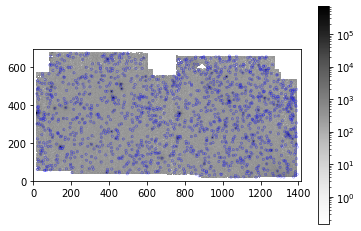

In [5]:
daofind = DAOStarFinder(threshold = 4. * std, fwhm = 3.) # could use a sigma*gaussian_sigma_to_fwhm instead (see PSF tutorial)
sources = daofind(data)
#print(sources)

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
norm = LogNorm()
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.5)

In [6]:
print(sources)

 id      xcentroid      ...        flux                 mag         
---- ------------------ ... ------------------ ---------------------
   1 1044.0412513314898 ...    1.2707436211366   -0.2601448457851147
   2 1066.2796170133668 ...  1.040136920830885  -0.04272628105296327
   3  1175.856541822026 ... 1.1130357975700056  -0.11627283095606375
   4   1111.03029866327 ... 1.0115948696001411 -0.012516545280169858
   5 1323.0951845364384 ... 1.1846977706422603   -0.1840189280100289
   6 1374.7149632478327 ...  1.701575673226052   -0.5771281699940722
   7 1081.4618604626708 ... 1.0225434532883577  -0.02420443136195251
   8 1306.2872089368027 ...  1.610179772622762   -0.5171859166316443
   9 1290.6790069711915 ... 1.1661807701888003   -0.1669146895446958
  10 1193.3977569063193 ... 1.4430658835527839   -0.3982153984375615
 ...                ... ...                ...                   ...
1472  138.2043761262743 ...  3.216422998980167    -1.268432897176891
1473  456.9262426951838 ... 1.2544

In [7]:
#sources['xcentroid'].name = 'x_0'
#sources['ycentroid'].name = 'y_0'

fwhm = 3.   # trial value, may need to calculate properly
daogroup = DAOGroup(crit_separation = 4. * fwhm) # from tests, 4ish looks decent
star_groups = daogroup(sources)
#print(star_groups)

star_groups = star_groups.group_by('group_id')
print(star_groups)

KeyError: 'x_0'

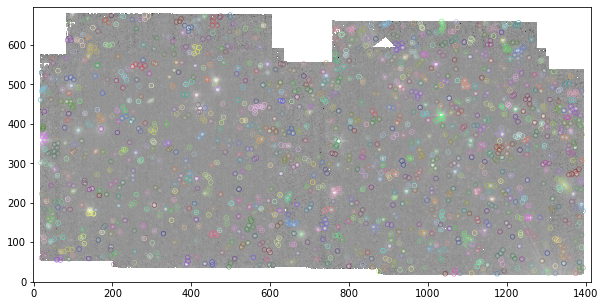

In [70]:
ncolors = max(star_groups['group_id'])
cmap = make_random_cmap(ncolors=ncolors, seed=1612)

plt.imshow(data, origin='lower', norm = LogNorm(), interpolation='nearest', cmap='Greys_r')
for i, group in enumerate(star_groups.groups):
    xypos = np.transpose([group['x_0'], group['y_0']])
    ap = CircularAperture(xypos, r=6.)
    ap.plot(color=cmap.colors[i], lw=.5)

#plt.savefig('images/groups_test_01.png', dpi=500)
plt.gcf().set_size_inches(10, 6)
plt.show()

In [78]:
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma = 3.) # sigma (width of gaussiann psf) is a guess again, could calculate?

photometry = ISPSF(finder = daofind,
                  group_maker = daogroup,
                  bkg_estimator = mmm_bkg,
                  psf_model = psf_model,
                  fitter = fitter,
                  fitshape = (11, 11),
                  niters = 1)
result = photometry(image = data)
residual_image = photometry.get_residual_image()

ValueError: cannot convert float NaN to integer